# GEE score tests

This notebook uses simulation to demonstrate robust GEE score tests.  These tests can be used in a GEE analysis to compare nested hypotheses about the mean structure.  The tests are robust to miss-specification of the working correlation model, and to certain forms of misspecification of the variance structure (e.g. as captured by the scale parameter in a quasi-Poisson analysis).

The data are simulated as clusters, where there is dependence within but not between clusters.  The cluster-wise dependence is induced using a copula approach.  The data marginally follow a negative binomial (gamma/Poisson) mixture.

The level and power of the tests are considered below to assess the performance of the tests.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats.distributions import norm, poisson
import statsmodels.api as sm
import matplotlib.pyplot as plt

The function defined in the following cell uses a copula approach to simulate correlated random values that marginally follow a negative binomial distribution.  The input parameter `u` is an array of values in (0, 1).  The elements of `u` must be marginally uniformly distributed on (0, 1).  Correlation in `u` will induce correlations in the returned negative binomial values.  The array parameter `mu` gives the marginal means, and the scalar parameter `scale` defines the mean/variance relationship (the variance is `scale` times the mean).  The lengths of `u` and `mu` must be the same.

In [2]:
def negbinom(u, mu, scale):
    p = (scale - 1) / scale
    r = mu * (1 - p) / p
    x = np.random.gamma(r, p / (1 - p), len(u))
    return poisson.ppf(u, mu=x)

Below are some parameters that govern the data used in the simulation.

In [3]:
# Sample size
n = 1000

# Number of covariates (including intercept) in the alternative hypothesis model
p = 5

# Cluster size
m = 10

# Intraclass correlation (controls strength of clustering)
r = 0.5

# Group indicators
grp = np.kron(np.arange(n/m), np.ones(m))

The simulation uses a fixed design matrix.

In [4]:
# Build a design matrix for the alternative (more complex) model
x = np.random.normal(size=(n, p))
x[:, 0] = 1

The null design matrix is nested in the alternative design matrix.  It has rank two less than the alternative design matrix.

In [5]:
x0 = x[:, 0:3]

The GEE score test is robust to dependence and overdispersion.  Here we set the overdispersion parameter.  The variance of the negative binomial distribution for each observation is equal to `scale` times its mean value.

In [6]:
# Scale parameter for negative binomial distribution
scale = 10

In the next cell, we set up the mean structures for the null and alternative models

In [7]:
# The coefficients used to define the linear predictors
coeff = [[4, 0.4, -0.2], [4, 0.4, -0.2, 0, -0.04]]

# The linear predictors
lp = [np.dot(x0, coeff[0]), np.dot(x, coeff[1])]

# The mean values
mu = [np.exp(lp[0]), np.exp(lp[1])]

Below is a function that carries out the simulation.

In [8]:
# hyp = 0 is the null hypothesis, hyp = 1 is the alternative hypothesis.
# cov_struct is a statsmodels covariance structure
def dosim(hyp, cov_struct=None, mcrep=500):
    
    # Storage for the simulation results
    scales = [[], []]
    
    # P-values from the score test
    pv = []
    
    # Monte Carlo loop
    for k in range(mcrep):

        # Generate random "probability points" u  that are uniformly 
        # distributed, and correlated within clusters
        z = np.random.normal(size=n)
        u = np.random.normal(size=n//m)
        u = np.kron(u, np.ones(m))
        z = r*z +np.sqrt(1-r**2)*u
        u = norm.cdf(z)

        # Generate the observed responses
        y = negbinom(u, mu=mu[hyp], scale=scale)

        # Fit the null model
        m0 = sm.GEE(y, x0, groups=grp, cov_struct=cov_struct, family=sm.families.Poisson())
        r0 = m0.fit(scale='X2')
        scales[0].append(r0.scale)
        
        # Fit the alternative model
        m1 = sm.GEE(y, x, groups=grp, cov_struct=cov_struct, family=sm.families.Poisson())
        r1 = m1.fit(scale='X2')
        scales[1].append(r1.scale)
        
        # Carry out the score test
        st = m1.compare_score_test(r0)
        pv.append(st["p-value"])

    pv = np.asarray(pv)
    rslt = [np.mean(pv), np.mean(pv < 0.1)]
    
    return rslt, scales

Run the simulation using the independence working covariance structure.  We expect the mean to be around 0 under the null hypothesis, and much lower under the alternative hypothesis.  Similarly, we expect that under the null hypothesis, around 10% of the p-values are less than 0.1, and a much greater fraction of the p-values are less than 0.1 under the alternative hypothesis.

In [9]:
rslt, scales = [], []

for hyp in 0, 1:
    s, t = dosim(hyp, sm.cov_struct.Independence())
    rslt.append(s)
    scales.append(t)
    
rslt = pd.DataFrame(rslt, index=["H0", "H1"], columns=["Mean", "Prop(p<0.1)"])

print(rslt)

        Mean  Prop(p<0.1)
H0  0.496125        0.094
H1  0.043429        0.880


Next we check to make sure that the scale parameter estimates are reasonable. We are assessing the robustness of the GEE score test to dependence and overdispersion, so here we are confirming that the overdispersion is present as expected.

Text(0, 0.5, 'Estimated scale')

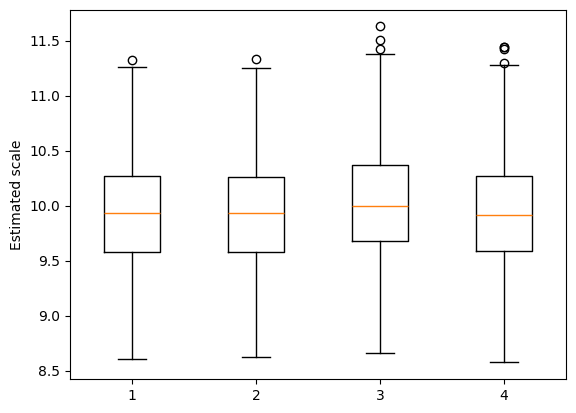

In [10]:
_ = plt.boxplot([scales[0][0], scales[0][1], scales[1][0], scales[1][1]])
plt.ylabel("Estimated scale")

Next we conduct the same analysis using an exchangeable working correlation model.  Note that this will be slower than the example above using independent working correlation, so we use fewer Monte Carlo repetitions.

In [11]:
rslt, scales = [], []

for hyp in 0, 1:
    s, t = dosim(hyp, sm.cov_struct.Exchangeable(), mcrep=100)
    rslt.append(s)
    scales.append(t)
    
rslt = pd.DataFrame(rslt, index=["H0", "H1"], columns=["Mean", "Prop(p<0.1)"])

print(rslt)

        Mean  Prop(p<0.1)
H0  0.493298         0.07
H1  0.031790         0.90
